**Let's prepare the data:**

In [158]:
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr 
from scipy.stats import linregress
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score,normalized_mutual_info_score
from pingouin import distance_corr,linear_regression
from math import ceil, floor

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from hurst import compute_Hc
import hfda
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 8)})

In [3]:
inflation= pd.read_csv('data/inflation.csv', sep=",")
monetary_base= pd.read_csv('data/monetary_base.csv', sep=",", thousands='.')

In [4]:
inflation['Dates'] = pd.to_datetime(inflation['Dates'], format='%d/%m/%Y')    
inflation.index = inflation['Dates']
inflation = inflation.drop(['Dates'], axis=1)

In [5]:
monetary_base['Dates'] = pd.to_datetime(monetary_base['Dates'], format='%d/%m/%Y')    
monetary_base.index = monetary_base['Dates']
monetary_base = monetary_base.drop(['Dates'], axis=1)

[None]

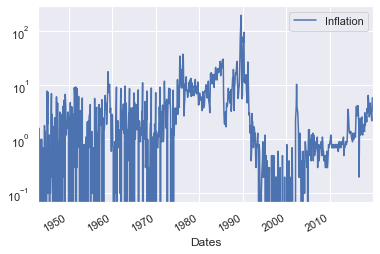

In [6]:
ax = inflation.plot()
ax.set(yscale="log")

[None]

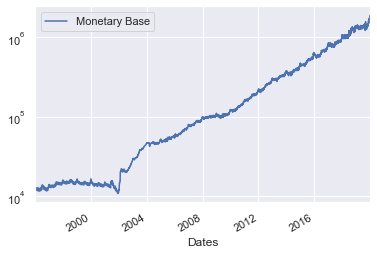

In [7]:
ax = monetary_base.plot()
ax.set(yscale="log")

In [8]:
inflation_1996 = {}
monetary_base_change_1996 = {}
data_1996 = {}
months = [1, 3, 6, 12]
for m in months:
    inflation_1996[m] = inflation.truncate(before = '1996-01-01')
    inflation_1996[m] = inflation_1996[m].apply(lambda x : x/100+1)
    inflation_1996[m] = inflation_1996[m].resample(str(m) + 'M').apply(lambda x : x.cumprod()[-1])
    inflation_1996[m] = inflation_1996[m].apply(lambda x : (x - 1) * 100)
    monetary_base_change_1996[m] = monetary_base.truncate(before='1996-01-01')
    monetary_base_change_1996[m] = monetary_base_change_1996[m].resample(str(m) + 'M').mean().pct_change()*100
    data_1996[m] = pd.DataFrame(monetary_base_change_1996[m])
    data_1996[m] = data_1996[m].assign(Inflation = inflation_1996[m]['Inflation']).dropna()

**Now let's calculate the pearson correlation:**

In [9]:
pearson_lagged = {}
for m in months:
    max_lag = 12*4//m
    correlation=[]
    for lag in np.arange(0, max_lag +1, 1):
        correlation.append(data_1996[m]['Inflation'].corr(data_1996[m]['Monetary Base'].shift(lag)))
    pearson_lagged[m]=correlation

In [10]:
to_plot = pd.DataFrame()
for m in months:
    to_plot=to_plot.append(pd.DataFrame([np.linspace(0,4,len(pearson_lagged[m])),pearson_lagged[m],[str(m)+ 'm']*len(pearson_lagged[m])]).T)
to_plot=to_plot.rename(columns={2:'months'})

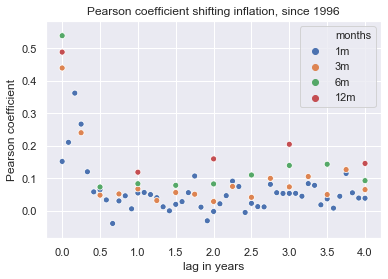

In [11]:
ax = sns.scatterplot(x= to_plot[0], y = to_plot[1], data = to_plot, hue = 'months')
ax.set(xlabel = 'lag in years', ylabel = 'Pearson coefficient', title = 'Pearson coefficient shifting inflation, since 1996')
ax

In [12]:
to_plot_heatmap = pd.DataFrame()
b=[]
for m in months:
    a=[ceil(m / 2)]+[m]*(48 // m-1) + [ceil(m / 2) + (m + 1)%2]
    to_plot_heatmap = to_plot_heatmap.append(pd.DataFrame([np.linspace(0, 4, 49), np.repeat(pearson_lagged[m], a),[m]*49]).T)
    b.append(np.repeat(pearson_lagged[m], a))
to_plot_heatmap = to_plot_heatmap.rename(columns = {0 : 'Lag in years', 2 : 'Months averaged'})

In [13]:
b=np.array(b)

[]

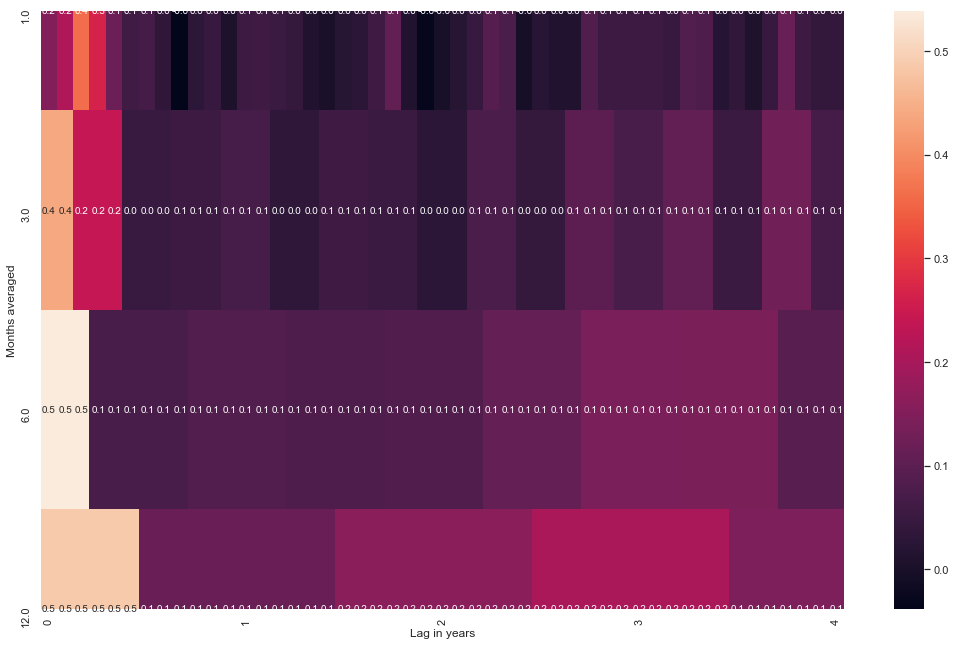

In [14]:
plt.figure(figsize=(18,11))

figure = to_plot_heatmap.pivot("Months averaged", 'Lag in years', 1)
sns.heatmap(figure,annot = b, fmt='.1f')
plt.xticks(np.arange(49) + 0.5, ['0'] + [None]*11 + ['1']+ [None]*11 + ['2'] + [None]*11 + ['3'] + [None]*11 + ['4'])
plt.plot()

Scatterplot x=Change in Monetary Base and y= Inflation rate

Text(0.5, 0, 'Change MB')

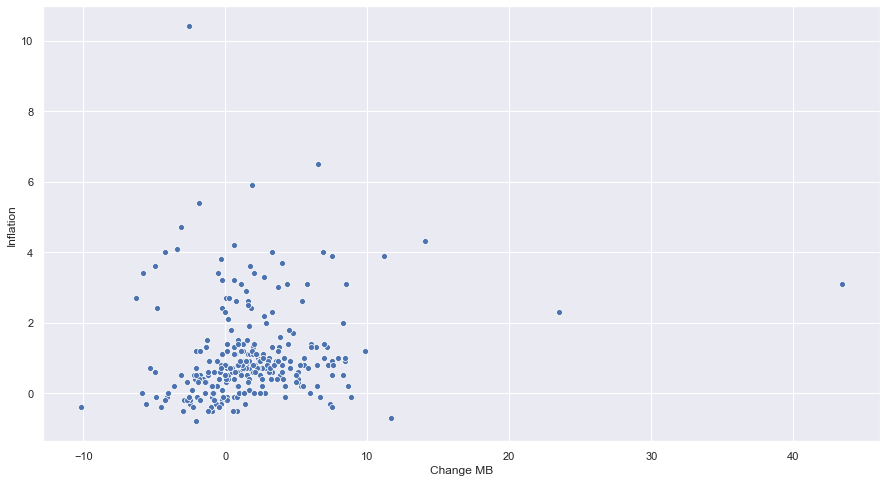

In [173]:
ax = sns.scatterplot(x=data_1996[1]['Monetary Base'],y=data_1996[1]['Inflation'])
ax.set_xlabel('Change MB')


**Hurst Exponent calculation**
The calculation is made assuming the series are 

In [53]:
H_Change_MB, c, data = compute_Hc(data_1996[1]['Monetary Base'].values, kind='change', simplified=True)
H_Change_MB

0.7993360835844703

In [69]:
H_Inflation, c, data = compute_Hc(data_1996[1]['Inflation'].values, kind='change', simplified=True)
H_Inflation

0.5275340813626709

H index calculated with kind= 'price' (a series is a cumulative product of changes)

In [67]:
Cumulative_Inflation= inflation.truncate(before = '1996-01-01')
Cumulative_Inflation= Cumulative_Inflation.apply(lambda x : x/100+1)
Cumulative_Inflation= Cumulative_Inflation.resample(str(1) + 'M').apply(lambda x : x.cumprod()[-1])

In [70]:
H_Inflation, c, data = compute_Hc(Cumulative_Inflation, kind='price', simplified=True)
H_Inflation

0.5178480575428585

Change in MB has a **persistent behavior**, but Inflation does not have persistence 

**calculating H index with a rolling window**

In [143]:
roll_days = 100
roll_Change_MB = data_1996[1]['Monetary Base'].rolling(roll_days)
roll_inflation = data_1996[1]['Inflation'].rolling(roll_days)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


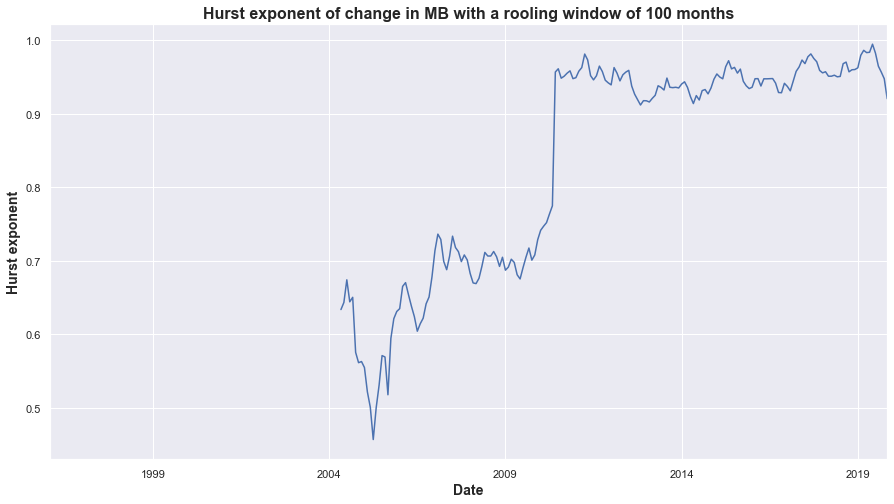

In [155]:
ax = roll_Change_MB.apply(lambda x : compute_Hc(x, kind = 'change', simplified=True)[0]).plot()
ax.set_title('Hurst exponent of change in MB with a rooling window of 100 months', weight='bold', fontsize = 6)
ax.set_ylabel('Hurst exponent', weight='bold', fontsize = 14)
ax.set_xlabel('Date',weight = 'bold', fontsize = 14)
ax

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


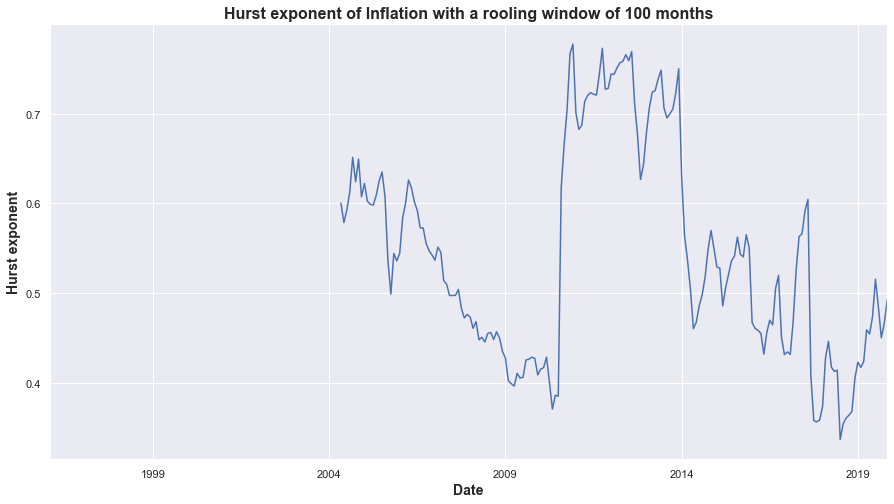

In [156]:
ax = roll_inflation.apply(lambda x : compute_Hc(x, kind='change', simplified=True)[0]).plot()
ax.set_title('Hurst exponent of Inflation with a rooling window of 100 months', weight = 'bold', fontsize = 16)
ax.set_ylabel('Hurst exponent', weight = 'bold',fontsize = 14)
ax.set_xlabel('Date', weight = 'bold', fontsize = 14)
ax

The behavior of the inflation seems more complicated than change in MB

Calculation of fractal dimension using Higuchi Fractal Dimension Analysis

In [166]:
D = []
for k_max in np.arange(6,60,5):
    d.append
hfda.measure(data_1996[1]['Monetary Base'], k_max)

1.9790724145979097